## Notebook to browse the detected ieQTL result for items of interest

In [1]:
!date

Sat Jun 19 04:16:33 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# parameters
cohort = 'pdbp'
version = 'amppdv1'
visit = 0
tissue = 'wb'
term = 'GRS'

In [4]:
# naming
cohort_version = f'{cohort}.{version}'
cohort_build = f'{cohort}.{tissue}{visit}'

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{cohort}'
genos_dir = f'{wrk_dir}/genotypes'
tensorqtl_dir = f'{wrk_dir}/tensorqtl'
results_dir = f'{wrk_dir}/results'
gwas_dir = f'{home_dir}/gwas'

# input files
gencode_pkl = f'{home_dir}/amppd/expression/gencode.v29.primary_assembly.annotation.pkl'
eqtl_results_file = f'{results_dir}/{cohort_build}.{term}.cis_qtl_top_assoc.txt.gz'
meta5_st2_clean_file = f'{gwas_dir}/pd.table_s2.clean.txt'

# output files

# constant values
autosomes = [str(x) for x in list(range(1,23))]
alpha_value = 0.05

# items of interest
genes = ['SNCA', 'LRRK2', 'GBA', 'CHURC1', 'RAB29', 'FBXL5', 'GCH1', 'STX4', 'TTC3', 'GPR65']

#### load the gencode annotations

In [5]:
%%time
gencode_df = pd.read_pickle(gencode_pkl)
# drop the ont and tag columns
discard_cols = gencode_df.columns[(gencode_df.columns.str.startswith('ont:')) |
                                (gencode_df.columns.str.startswith('tag:'))]
gencode_df.drop(columns=discard_cols, inplace=True)
# should only be autosomal but sometimes annotation quirks allow in others, so force
gencode_df = gencode_df.loc[(gencode_df['seqname'].str.startswith('chr')) & 
                           (~gencode_df['seqname'].isin(['chrX','chrY','chrM']))]
# every now and again having problem with mics_RNA genes mapping every chrom so drop
gencode_df = gencode_df.loc[~gencode_df['gene_type'].isin(['misc_RNA'])]
print(gencode_df.shape)
display(gencode_df.head())

(2636995, 22)


,seqname,source,feature,start,end,score,strand,frame,ccdsid,exon_id,...,gene_name,gene_type,havana_gene,havana_transcript,level,protein_id,transcript_id,transcript_name,transcript_support_level,transcript_type
0,chr1,HAVANA,gene,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,NaN,2,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,NaN,NaN,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
2,chr1,HAVANA,exon,11869,12227,.,+,.,NaN,ENSE00002234944.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
3,chr1,HAVANA,exon,12613,12721,.,+,.,NaN,ENSE00003582793.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript
4,chr1,HAVANA,exon,13221,14409,.,+,.,NaN,ENSE00002312635.1,...,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2,OTTHUMT00000362751.1,2,NaN,ENST00000456328.2,DDX11L1-202,1,processed_transcript


CPU times: user 5.68 s, sys: 2.57 s, total: 8.26 s
Wall time: 8.25 s


#### load the detected eQTL

In [6]:
eqtl_df = pd.read_csv(eqtl_results_file)
print(eqtl_df.shape)
number_genes = len(eqtl_df['phenotype_id'].unique())
print(f'detected eqtl for {number_genes} genes')
display(eqtl_df.head())

(3, 19)
detected eqtl for 3 genes


,Unnamed: 0,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_g,b_g,b_g_se,pval_i,b_i,b_i_se,pval_gi,b_gi,b_gi_se,tests_emt,pval_emt,pval_adj_bh
0,35,ENSG00000174106.2,rs61567235,-39022,0.067990,152,161,2.800220e-06,-1.26205,0.268069,0.023831,-0.565651,0.249980,1.262800e-09,3.68773,0.602439,451,5.695230e-07,0.004053
1,5961,ENSG00000214401.4,rs7209792,-605852,0.384291,725,910,4.561160e-27,1.34048,0.121330,0.481598,0.221524,0.314684,3.046910e-09,-1.69033,0.282902,333,1.014620e-06,0.004814
2,6966,ENSG00000119185.12,rs12473519,-332564,0.051098,117,121,1.954140e-09,-1.83764,0.303785,0.194627,-0.306201,0.235947,4.320540e-10,4.33920,0.689261,1122,4.847640e-07,0.004053


#### grab the max pval_nominal and max pval_beta

In [7]:
max_pvalue = eqtl_df['pval_gi'].max()
max_pval_adj = eqtl_df['pval_adj_bh'].max()
print(f'max p-value: {max_pvalue} and p-values(adj_bh): {max_pval_adj}')
max_pvalue = 0.001

max p-value: 3.04691e-09 and p-values(adj_bh): 0.0048137


In [8]:
genes_oi_df = gencode_df.loc[gencode_df['gene_name'].isin(genes)]
print(genes_oi_df.shape)
gene_ids = genes_oi_df['gene_id'].unique()
print(gene_ids)
gene_names = genes_oi_df['gene_name'].unique()
print(gene_names)
genes_oi_df.head()

(2179, 22)
['ENSG00000177628.15' 'ENSG00000117280.12' 'ENSG00000118564.14'
 'ENSG00000145335.15' 'ENSG00000188906.15' 'ENSG00000131979.18'
 'ENSG00000258289.8' 'ENSG00000140030.5' 'ENSG00000103496.14'
 'ENSG00000182670.13']
['GBA' 'RAB29' 'FBXL5' 'SNCA' 'LRRK2' 'GCH1' 'CHURC1' 'GPR65' 'STX4'
 'TTC3']


,seqname,source,feature,start,end,score,strand,frame,ccdsid,exon_id,...,gene_name,gene_type,havana_gene,havana_transcript,level,protein_id,transcript_id,transcript_name,transcript_support_level,transcript_type
163215,chr1,HAVANA,gene,155234452,155244699,.,-,.,NaN,NaN,...,GBA,protein_coding,OTTHUMG00000035841.2,NaN,2,NaN,NaN,NaN,NaN,NaN
163216,chr1,HAVANA,transcript,155234452,155241234,.,-,.,CCDS1102.1,NaN,...,GBA,protein_coding,OTTHUMG00000035841.2,OTTHUMT00000087203.1,2,ENSP00000357357.3,ENST00000368373.7,GBA-202,1,protein_coding
163217,chr1,HAVANA,exon,155241086,155241234,.,-,.,CCDS1102.1,ENSE00001890492.1,...,GBA,protein_coding,OTTHUMG00000035841.2,OTTHUMT00000087203.1,2,ENSP00000357357.3,ENST00000368373.7,GBA-202,1,protein_coding
163218,chr1,HAVANA,CDS,155241086,155241112,.,-,0,CCDS1102.1,ENSE00001890492.1,...,GBA,protein_coding,OTTHUMG00000035841.2,OTTHUMT00000087203.1,2,ENSP00000357357.3,ENST00000368373.7,GBA-202,1,protein_coding
163219,chr1,HAVANA,start_codon,155241110,155241112,.,-,0,CCDS1102.1,ENSE00001890492.1,...,GBA,protein_coding,OTTHUMG00000035841.2,OTTHUMT00000087203.1,2,ENSP00000357357.3,ENST00000368373.7,GBA-202,1,protein_coding


In [9]:
eqtl_genes_oi_df = eqtl_df.loc[eqtl_df['phenotype_id'].isin(genes_oi_df['gene_id'])]
print(eqtl_genes_oi_df.shape)
print(eqtl_genes_oi_df['phenotype_id'].unique())
print(genes_oi_df.loc[genes_oi_df['gene_id'].isin(eqtl_genes_oi_df['phenotype_id']), 
                      ['gene_name']]['gene_name'].unique())

(0, 19)
[]
[]


#### load the variants of interest

In [10]:
variants_oi_df = pd.read_csv(meta5_st2_clean_file, sep='\t')
print(variants_oi_df.shape)
variants_oi_df.head()

(91, 12)


,SNP,CHR,BP,Nearest_Gene,QTL_Nominated_Gene,Effect_allele,Other_allele,EAF,Beta_all_studies,SE_all_studies,P_all_studies,P_COJO_all_studies
0,rs114138760,1,154898185,PMVK,NaN,c,g,0.0112,0.2812,0.0478,4.190000e-09,1.090000e-08
1,rs35749011,1,155135036,KRTCAP2,EFNA3,a,g,0.0169,0.6068,0.0342,1.720000e-70,3.820000e-77
2,rs76763715,1,155205634,GBAP1,NaN,t,c,0.9953,-0.7467,0.0765,1.590000e-22,9.900000e-23
3,rs6658353,1,161469054,FCGR2A,FCGR2A,c,g,0.5011,0.0650,0.0094,6.100000e-12,4.690000e-12
4,rs11578699,1,171719769,VAMP4,VAMP4,t,c,0.1949,-0.0704,0.0120,4.470000e-09,4.450000e-09


#### see if any of the independent significant results happen to be risk independent variants

In [11]:
def check_eqtls_for_variants(eqtl_df, variants_df, gencode_df):
    eqtl_variants_oi_df = eqtl_df.loc[eqtl_df['variant_id'].isin(variants_df['SNP'])]
    print(eqtl_variants_oi_df.shape)
    this_cnt = len(eqtl_variants_oi_df['variant_id'].unique())
    print(f'variants {this_cnt}')
    print(eqtl_variants_oi_df['variant_id'].unique())
    this_cnt = len(eqtl_variants_oi_df['phenotype_id'].unique())
    print(f'genes {this_cnt}')
    oi_genes = gencode_df.loc[gencode_df['gene_id'].isin(eqtl_variants_oi_df['phenotype_id']), 
                              ['gene_name']]['gene_name'].unique()
    print(oi_genes)
    return oi_genes

In [12]:
these_genes = check_eqtls_for_variants(eqtl_df, variants_oi_df, gencode_df)
if len(these_genes) > 0:
    genes = set(genes) | set(these_genes)
    print(genes)

(0, 19)
variants 0
[]
genes 0
[]


#### now load rest of results and see if risk index variants are eQTL

In [13]:
for chrom in autosomes:
    print(f'checking chromosome {chrom}')
    chrom_eqtl_df = pd.read_parquet(f'{tensorqtl_dir}/{cohort_build}.{term}.cis_qtl_pairs.chr{chrom}.parquet')
#     oi_chrom_eqtl_df = chrom_eqtl_df.loc[chrom_eqtl_df['pval_nominal'] < max_pvalue]
    oi_chrom_eqtl_df = chrom_eqtl_df.loc[chrom_eqtl_df['pval_gi'] < max_pvalue]
    these_genes = check_eqtls_for_variants(oi_chrom_eqtl_df, variants_oi_df, gencode_df)
#     if len(these_genes) > 0:
#         genes = set(genes) | set(these_genes)
    
print(genes)    

checking chromosome 1
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 2
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 3
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 4
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 5
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 6
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 7
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 8
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 9
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 10
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 11
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 12
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 13
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 14
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 15
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 16
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 17
(0, 15)
variants 0
[]
genes 0
[]
checking chromosome 18
(0, 15)
variants 0
[]
genes 0
[]
c

#### check all the genes of interest regardless of detectable eQTL

In [14]:
#plot local manhattan for gene eQTL
def plot_eqtl_manhattan(gene_id, gene_name, gene_chrom, gene_start, gene_stop, eqtl_df):
    print(f'{gene_name} {gene_id}')
    print(f'gene {gene_name} is on {gene_chrom} from {gene_start} to {gene_stop}')

    #pull in all results for the gene from chromosome for all visits
    gene_results_df = eqtl_df.loc[eqtl_df['phenotype_id'] == gene_id]
    print(gene_results_df.shape)

    if not gene_results_df is None and gene_results_df.shape[0] > 0:
#         #get suggestive results counts
#         temp_results_df = gene_results_df.loc[gene_results_df['bh_fdr'] <= alpha_value]
#         print(temp_results_df.shape)

        #create some cleaner data columns for plotting purposes
#         gene_results_df['log10_bh_pvalue'] = np.log10(gene_results_df['bh_fdr'])*-1
        gene_results_df['log10_pvalue'] = np.log10(gene_results_df['pval_gi'])*-1
        gene_results_df['z_score'] = gene_results_df['b_gi']/gene_results_df['b_gi_se']
        gene_results_df['z_score_abs'] = np.abs(gene_results_df['z_score'])

        #now actually do the plotting
        sns.set(style='darkgrid')
#         sns.relplot(x='tss_distance',y='log10_pvalue',size='z_score_abs', \
#                     alpha=.5, palette="dark", height=12, data=gene_results_df)
        sns.relplot(x='pos',y='log10_pvalue',size='z_score_abs', \
                    alpha=.5, palette="dark", height=12, data=gene_results_df)        

        min_y = round(min(gene_results_df['log10_pvalue']))

        plt.plot([gene_start, gene_stop], [min_y, min_y], linewidth=3)
        plt.text(gene_stop+10000,min_y,gene_name,fontsize='small')
#         plt.plot([0, 0], [min_y, min_y], linewidth=3)
#         plt.text(0+10000,min_y,gene_name,fontsize='small')


        plt.title(f'{gene_name} eQTL',fontsize='large') 
        plt.show()

#     plot_out_file_name = f'{WRKDIR}/plink/images/{gene_name}.local_man.png'
#     plt.savefig(plot_out_file_name,format='png',dpi=600,bbox_inches='tight')
    
    return

In [15]:
genes_oi_df = gencode_df.loc[gencode_df['gene_name'].isin(genes)]
print(genes_oi_df.shape)
gene_ids = genes_oi_df['gene_id'].unique()
print(gene_ids)

(2179, 22)
['ENSG00000177628.15' 'ENSG00000117280.12' 'ENSG00000118564.14'
 'ENSG00000145335.15' 'ENSG00000188906.15' 'ENSG00000131979.18'
 'ENSG00000258289.8' 'ENSG00000140030.5' 'ENSG00000103496.14'
 'ENSG00000182670.13']


chr1
(5114862, 21)
(2445, 21)
GBA ENSG00000177628.15
gene GBA is on chr1 from 155234452 to 155244699
(2445, 21)


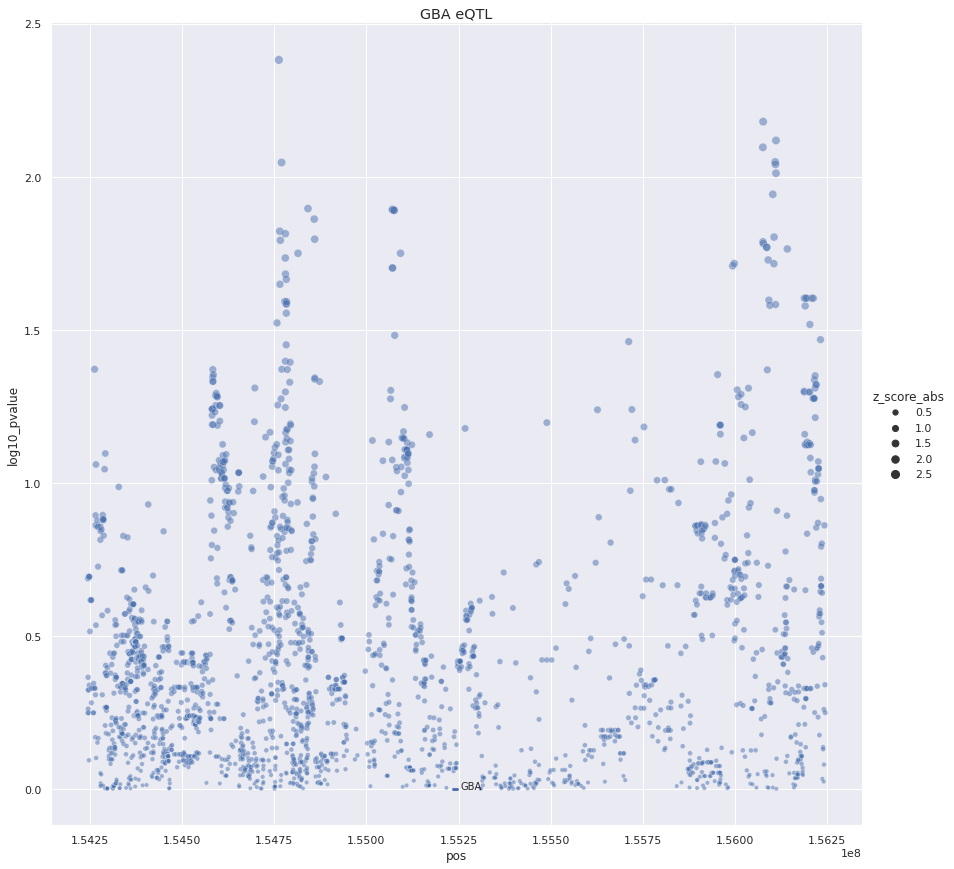

chr1
(5114862, 21)
(3587, 21)
RAB29 ENSG00000117280.12
gene RAB29 is on chr1 from 205767986 to 205775460
(3587, 21)


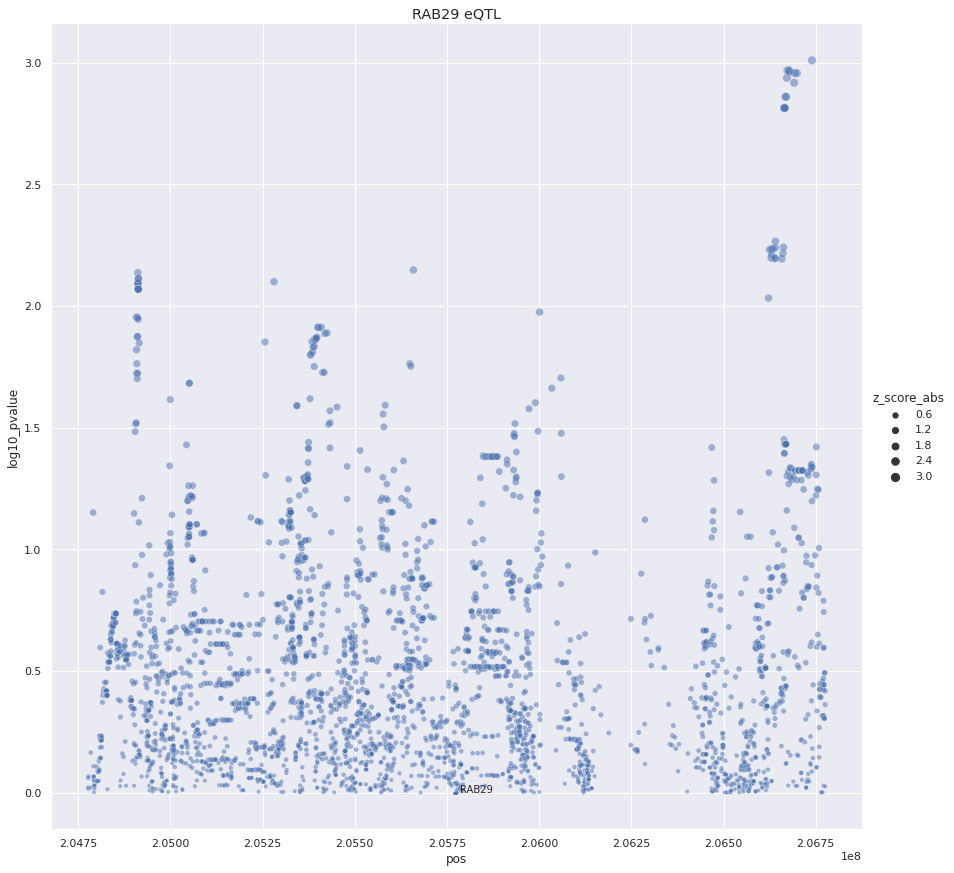

chr4
(2525343, 21)
(4681, 21)
FBXL5 ENSG00000118564.14
gene FBXL5 is on chr4 from 15604539 to 15681679
(4681, 21)


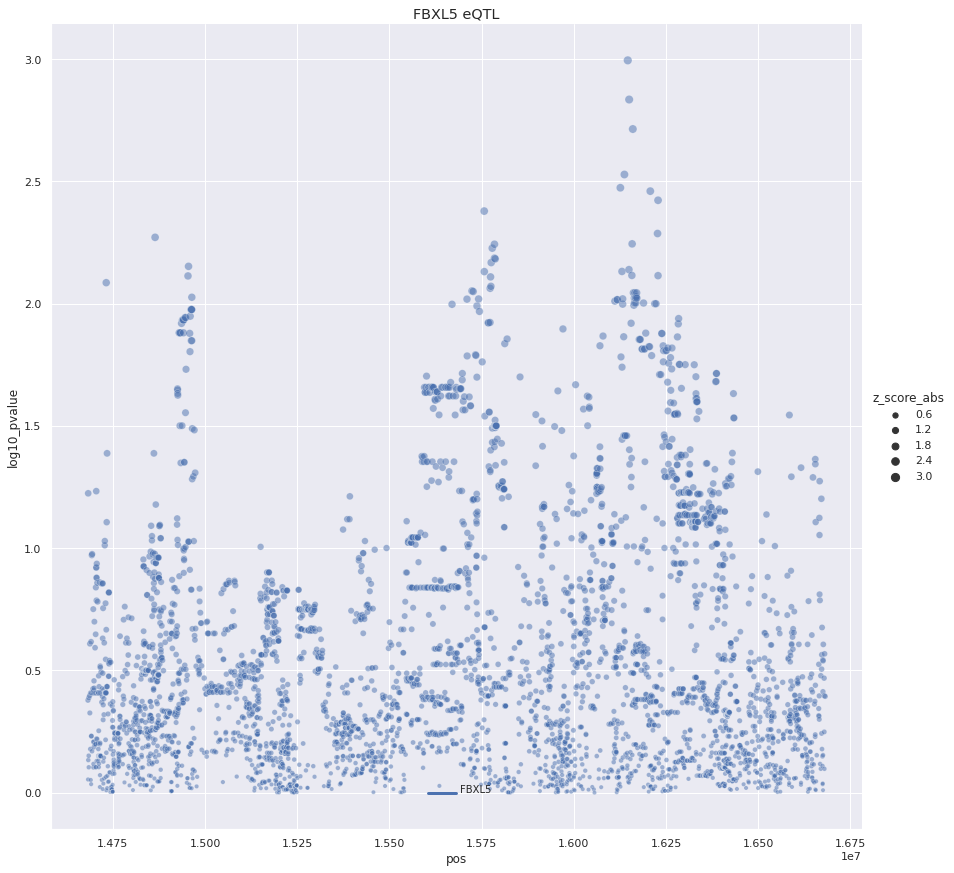

chr4
(2525343, 21)
(4448, 21)
SNCA ENSG00000145335.15
gene SNCA is on chr4 from 89724099 to 89838315
(4448, 21)


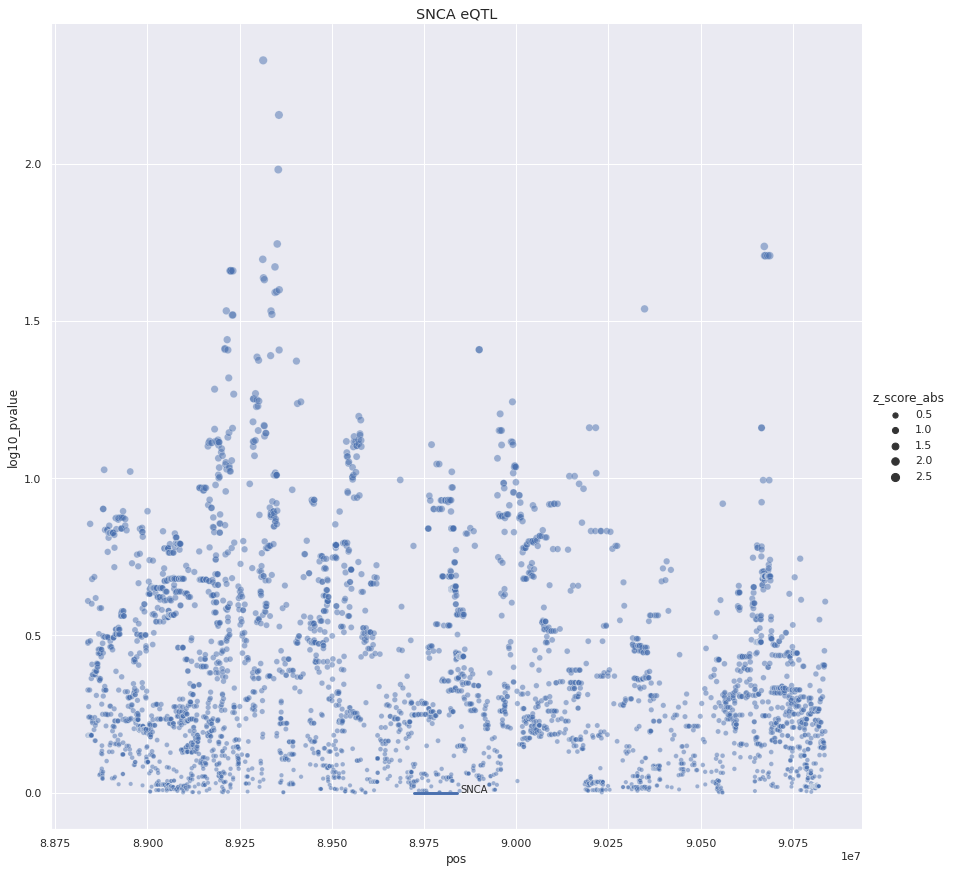

chr12
(3378684, 21)
(4329, 21)
LRRK2 ENSG00000188906.15
gene LRRK2 is on chr12 from 40196744 to 40369285
(4329, 21)


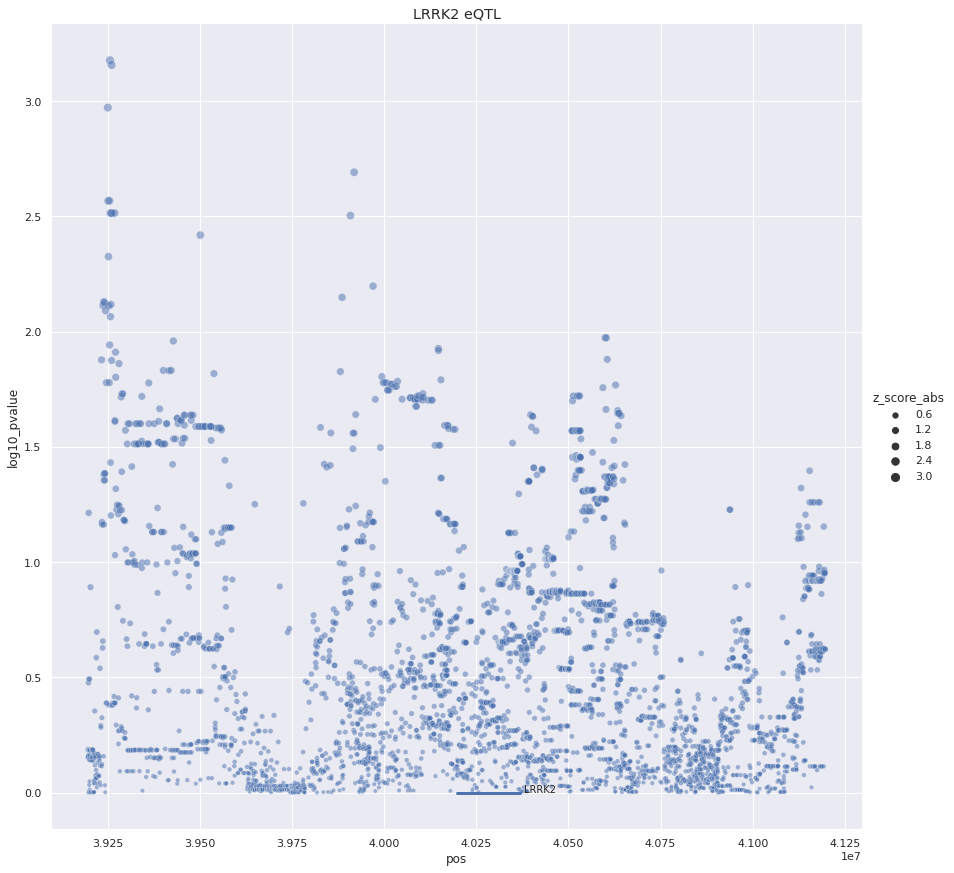

chr14
(2701675, 21)
(4192, 21)
GCH1 ENSG00000131979.18
gene GCH1 is on chr14 from 54842008 to 54902852
(4192, 21)


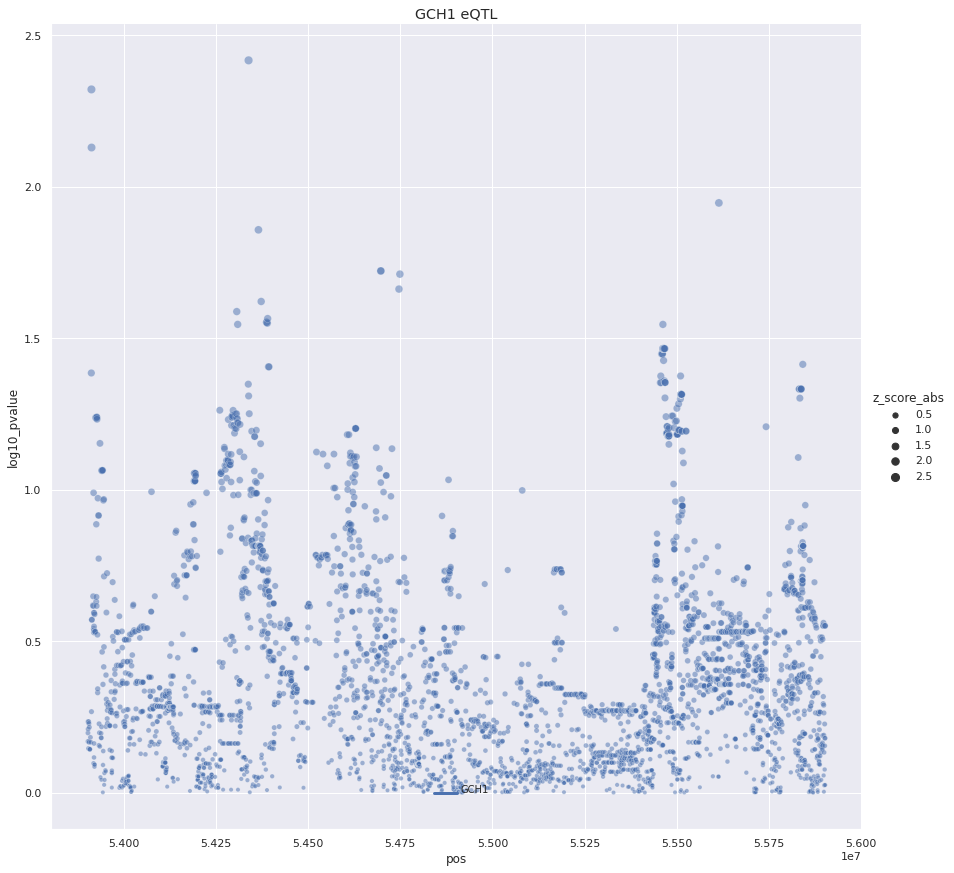

chr14
(2701675, 21)
(3885, 21)
CHURC1 ENSG00000258289.8
gene CHURC1 is on chr14 from 64914361 to 64944591
(3885, 21)


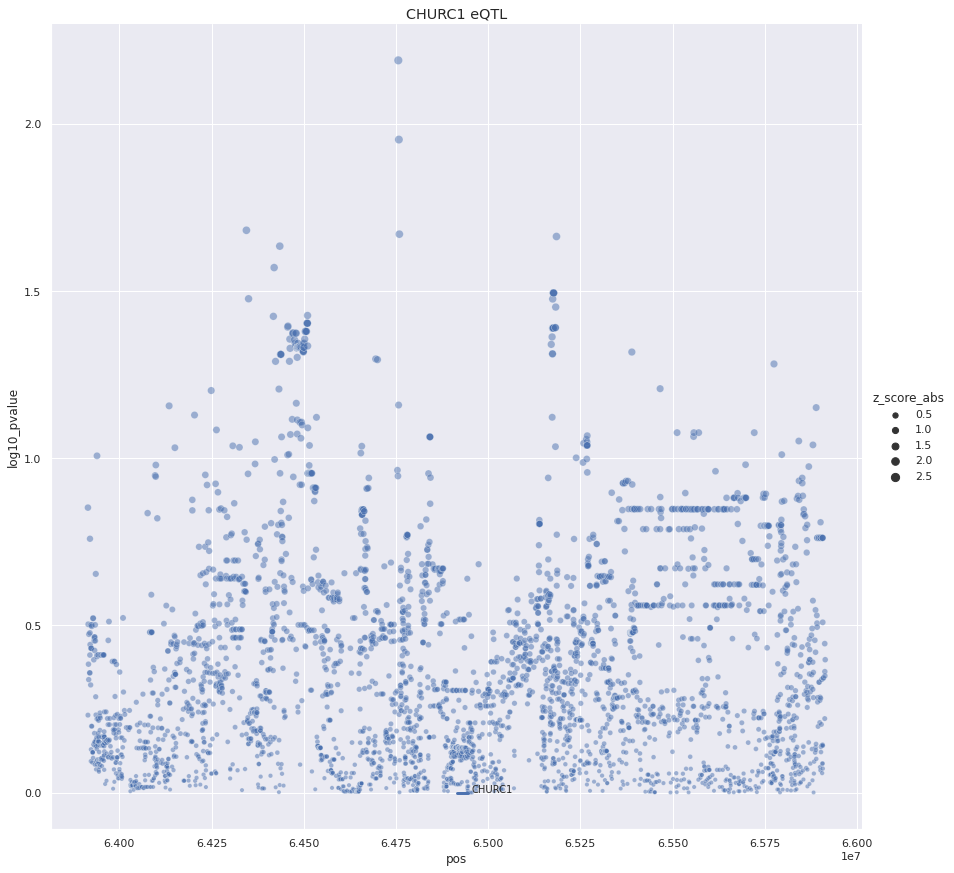

chr14
(2701675, 21)
(3985, 21)
GPR65 ENSG00000140030.5
gene GPR65 is on chr14 from 88005124 to 88014811
(3985, 21)


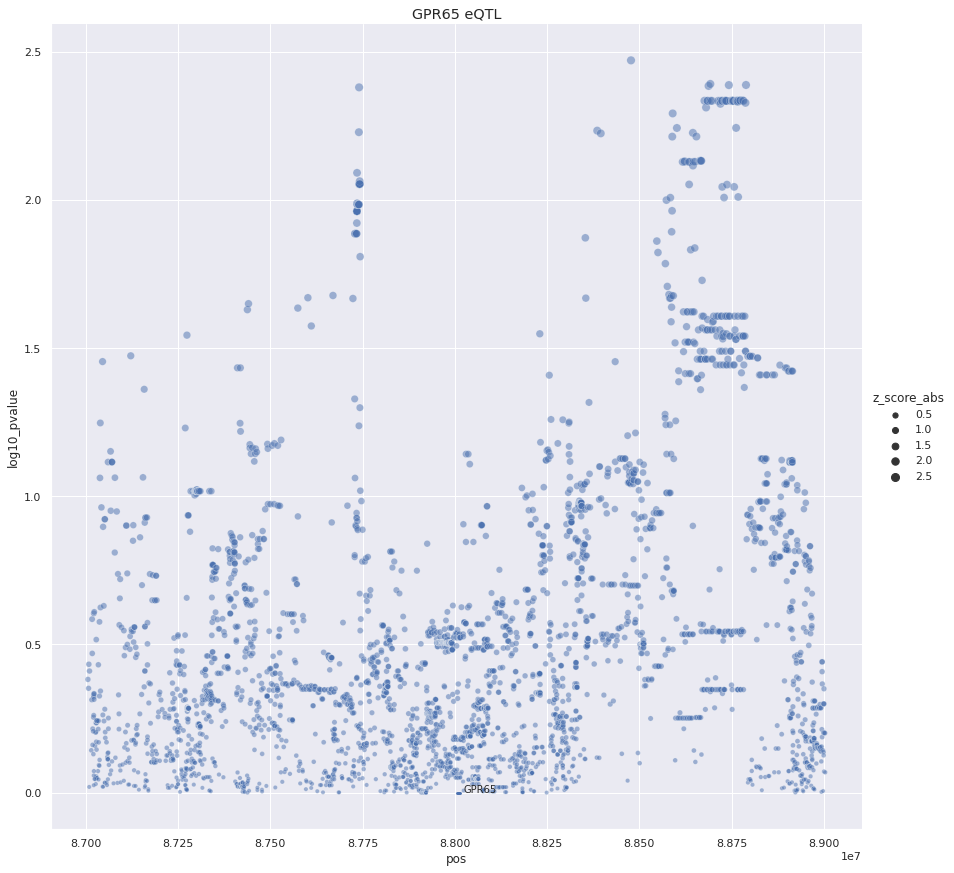

chr16
(2485789, 21)
(2024, 21)
STX4 ENSG00000103496.14
gene STX4 is on chr16 from 31032889 to 31042975
(2024, 21)


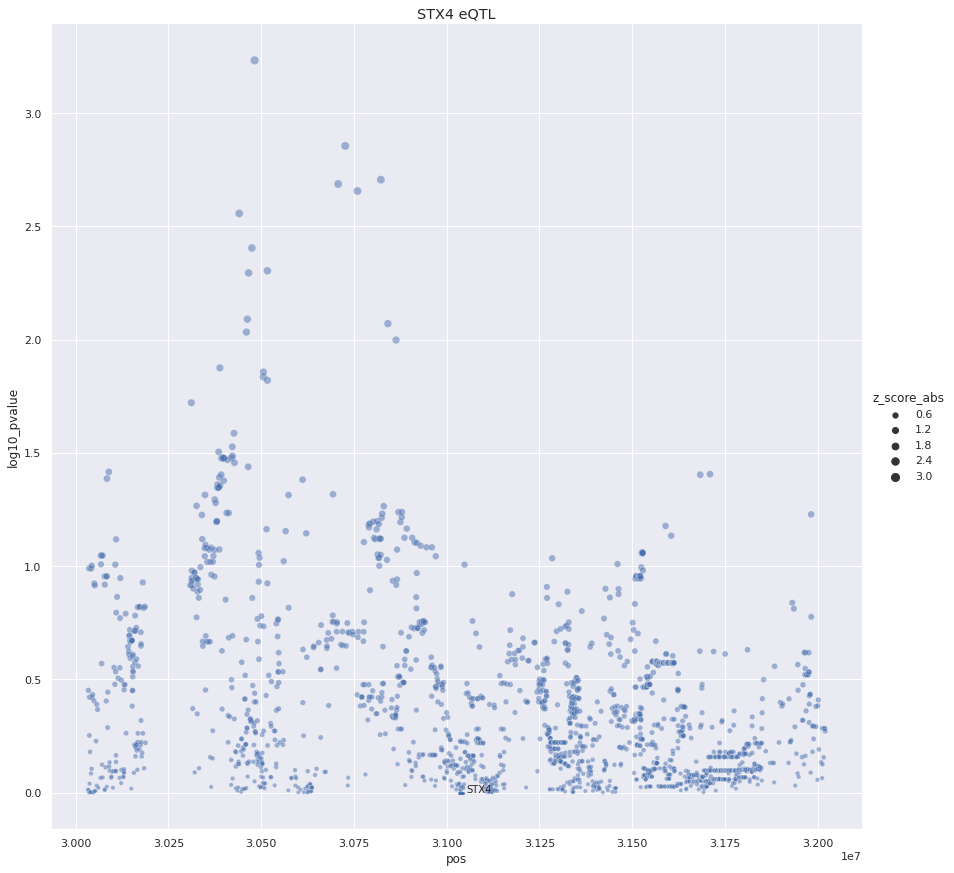

chr21
(677088, 21)
(4902, 21)
TTC3 ENSG00000182670.13
gene TTC3 is on chr21 from 37073226 to 37203112
(4902, 21)


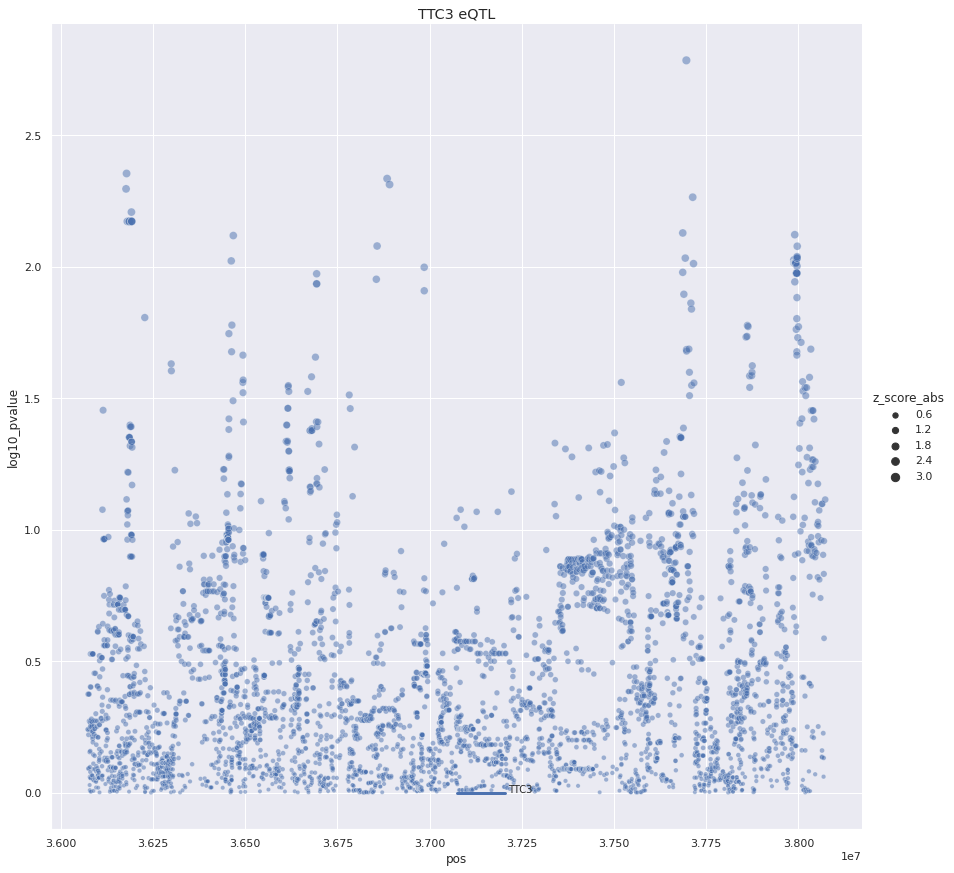

CPU times: user 1min 4s, sys: 9.45 s, total: 1min 13s
Wall time: 1min 6s


In [16]:
%%time

for gene_id in gene_ids:
    gene_df = genes_oi_df.loc[genes_oi_df['gene_id'] == gene_id]
    print(gene_df['seqname'].unique()[0])
    chrom = gene_df['seqname'].unique()[0]
    gene_name = gene_df['gene_name'].unique()[0]
    gene_start = gene_df['start'].min()
    gene_stop = gene_df['end'].max()
    # now load the chromosome eqtl results and extract specific gene results
    chrom_eqtl_df = pd.read_parquet(f'{tensorqtl_dir}/{cohort_build}.{term}.cis_qtl_pairs.{chrom}.parquet')
    chrom_bim_df = pd.read_csv(f'{genos_dir}/{cohort_version}.{chrom}.bfile.bim', 
                               header=None, sep='\s+')
    chrom_bim_df.columns = ['chr', 'name', 'cm', 'pos', 'a1', 'a2']
    chrom_eqtl_df = chrom_eqtl_df.merge(chrom_bim_df, how='inner', 
                                    left_on='variant_id', right_on='name')    
    print(chrom_eqtl_df.shape)
    gene_eqtl_df = chrom_eqtl_df.loc[chrom_eqtl_df['phenotype_id'] == gene_id]
    print(gene_eqtl_df.shape)
    plot_eqtl_manhattan(gene_id, gene_name, chrom, gene_start, gene_stop, gene_eqtl_df)